In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD,Adadelta,Adagrad
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K
from imutils import paths
import numpy as np
import random
import cv2
import os, time
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
class LausNet:
    @staticmethod
    def build(width, height, depth, classes):
    # initialize the model
        model = Sequential()
        inputShape = (height, width, depth)
        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            
        # First layer is a convolution with 20 functions and a kernel size of 5x5 (2 neighbor pixels on each side)
        model.add(Conv2D(20, (5, 5), padding="same",
            input_shape=inputShape))
        # our activation function is ReLU (Rectifier Linear Units)
        model.add(Activation("relu"))
        # second layer is maxpooling 2x2 that reduces our image resolution by half 
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # Third Layer - Convolution, twice the size of the first convoltion
        model.add(Conv2D(40, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        # Fifth Layer is Full connected flattened layer that makes our 3D images into 1D arrays
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the completed network architecture
        return model

In [3]:
# data files
imageDirectory = "images/"
model_file = "towel1.model"

In [4]:
# initialize the data and labels
print("Loading training images set...")
data = []
labels = []

Loading training images set...


In [5]:
# Set up the number of training passes (epochs), learning rate, and batch size
EPOCHS = 200
LEARNING_RATE = 1e-4
#LEARNING_RATE = LEARNING_RATE*100
#print(LEARNING_RATE)
BATCH_SIZE = 128

In [6]:
# grab the images from the directories and randomly shuffle them
imagePaths = sorted(list(paths.list_images(imageDirectory)))
# use a random seed number from the time clock
seed = 4#int(time.time() % 1000)
random.seed(seed)
random.shuffle(imagePaths)
print("number of images", len(imagePaths))
print(imagePaths[0])

number of images 292
images/True/color169.png


In [7]:
# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    #print(label)
    if label == "True":
        label = True
    else: 
        label = False
    labels.append(label)
    #print(imagePath)

In [8]:
# initialize the data and labels
#print("Loading training images set...")
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [9]:
# split the data between a testing set and a training set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10, random_state=seed)

In [10]:
# convert the labels from integers to vectors
trainY = to_categorical(trainY, num_classes=2)
testY = to_categorical(testY, num_classes=2)

In [11]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.2, 
                         shear_range=0.1, zoom_range=0.2, horizontal_flip=False, fill_mode="nearest")

In [12]:
# initialize the weights of the network
print("compiling CNN network...")
cnNetwork = LausNet.build(width=128, height=128, depth=3, classes=2)
#use adam optimizer.  tried SGD for comparison - needs more epochs (>100)
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / EPOCHS)
#opt = SGD(lr=LEARNING_RATE,decay=LEARNING_RATE / EPOCHS)

compiling CNN network...


In [13]:
# if we have more than two classes, use categorical crossentropy
cnNetwork.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
#cnNetwork.compile(Adam(lr=.0001),loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
# train the network - here is where the magic happens...
print("training network...")
print("length trainx", len(trainX)," length trainy ",len(trainY))

training network...
length trainx 262  length trainy  262


In [15]:
history = cnNetwork.fit_generator(aug.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                            validation_data=(testX, testY), steps_per_epoch=len(trainX) // BATCH_SIZE,
                            epochs=EPOCHS, verbose=1)

Epoch 1/200
2/2 [==============================] - 2s 1s/step - loss: 0.6506 - acc: 0.6875 - val_loss: 0.8275 - val_acc: 0.5333
Epoch 2/200
2/2 [==============================] - 0s 45ms/step - loss: 0.6234 - acc: 0.7057 - val_loss: 0.6566 - val_acc: 0.5333
Epoch 3/200
2/2 [==============================] - 0s 37ms/step - loss: 0.6462 - acc: 0.6018 - val_loss: 0.6365 - val_acc: 0.5333
Epoch 4/200
2/2 [==============================] - 0s 52ms/step - loss: 0.5986 - acc: 0.6875 - val_loss: 0.6569 - val_acc: 0.5333
Epoch 5/200
2/2 [==============================] - 0s 34ms/step - loss: 0.5858 - acc: 0.6599 - val_loss: 0.6686 - val_acc: 0.5333
Epoch 6/200
2/2 [==============================] - 0s 38ms/step - loss: 0.4968 - acc: 0.7536 - val_loss: 0.6788 - val_acc: 0.5333
Epoch 7/200
2/2 [==============================] - 0s 93ms/step - loss: 0.5489 - acc: 0.6836 - val_loss: 0.6234 - val_acc: 0.5333
Epoch 8/200
2/2 [==============================] - 0s 137ms/step - loss: 0.4707 - acc: 0.743

2/2 [==============================] - 0s 138ms/step - loss: 0.2640 - acc: 0.9083 - val_loss: 0.3905 - val_acc: 0.8333
Epoch 64/200
2/2 [==============================] - 1s 262ms/step - loss: 0.3873 - acc: 0.8359 - val_loss: 0.3381 - val_acc: 0.8667
Epoch 65/200
2/2 [==============================] - 0s 139ms/step - loss: 0.2676 - acc: 0.8778 - val_loss: 0.2794 - val_acc: 0.8667
Epoch 66/200
2/2 [==============================] - 0s 147ms/step - loss: 0.3441 - acc: 0.7719 - val_loss: 0.2745 - val_acc: 0.8667
Epoch 67/200
2/2 [==============================] - 1s 257ms/step - loss: 0.3385 - acc: 0.8086 - val_loss: 0.2862 - val_acc: 0.9000
Epoch 68/200
2/2 [==============================] - 0s 134ms/step - loss: 0.3435 - acc: 0.8452 - val_loss: 0.4156 - val_acc: 0.7667
Epoch 69/200
2/2 [==============================] - 0s 139ms/step - loss: 0.3182 - acc: 0.8299 - val_loss: 0.3558 - val_acc: 0.8667
Epoch 70/200
2/2 [==============================] - 1s 260ms/step - loss: 0.3326 - acc: 0

Epoch 125/200
2/2 [==============================] - 0s 139ms/step - loss: 0.3084 - acc: 0.8931 - val_loss: 0.2536 - val_acc: 0.9000
Epoch 126/200
2/2 [==============================] - 0s 138ms/step - loss: 0.2736 - acc: 0.8727 - val_loss: 0.2605 - val_acc: 0.9333
Epoch 127/200
2/2 [==============================] - 1s 258ms/step - loss: 0.2998 - acc: 0.8633 - val_loss: 0.2932 - val_acc: 0.9333
Epoch 128/200
2/2 [==============================] - 0s 139ms/step - loss: 0.2871 - acc: 0.9236 - val_loss: 0.2845 - val_acc: 0.9333
Epoch 129/200
2/2 [==============================] - 0s 150ms/step - loss: 0.2768 - acc: 0.9083 - val_loss: 0.2710 - val_acc: 0.9333
Epoch 130/200
2/2 [==============================] - 1s 262ms/step - loss: 0.3345 - acc: 0.8438 - val_loss: 0.2595 - val_acc: 0.9333
Epoch 131/200
2/2 [==============================] - 0s 143ms/step - loss: 0.3086 - acc: 0.8350 - val_loss: 0.2582 - val_acc: 0.9333
Epoch 132/200
2/2 [==============================] - 0s 138ms/step - 

2/2 [==============================] - 0s 135ms/step - loss: 0.5274 - acc: 0.8605 - val_loss: 0.2077 - val_acc: 0.9333
Epoch 187/200
2/2 [==============================] - 0s 250ms/step - loss: 0.2811 - acc: 0.8906 - val_loss: 0.2082 - val_acc: 0.9333
Epoch 188/200
2/2 [==============================] - 0s 135ms/step - loss: 0.3612 - acc: 0.8075 - val_loss: 0.2361 - val_acc: 0.9667
Epoch 189/200
2/2 [==============================] - 0s 136ms/step - loss: 0.2567 - acc: 0.9134 - val_loss: 0.2720 - val_acc: 0.9000
Epoch 190/200
2/2 [==============================] - 1s 255ms/step - loss: 0.2976 - acc: 0.8789 - val_loss: 0.2761 - val_acc: 0.9000
Epoch 191/200
2/2 [==============================] - 0s 136ms/step - loss: 0.2666 - acc: 0.9185 - val_loss: 0.2393 - val_acc: 0.9667
Epoch 192/200
2/2 [==============================] - 0s 137ms/step - loss: 0.4079 - acc: 0.8279 - val_loss: 0.2330 - val_acc: 0.9333
Epoch 193/200
2/2 [==============================] - 1s 251ms/step - loss: 0.2917 -

In [16]:
# save the CNN network weights to file
print("Saving Network Weights to file...")
cnNetwork.save(model_file)

Saving Network Weights to file...


In [17]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

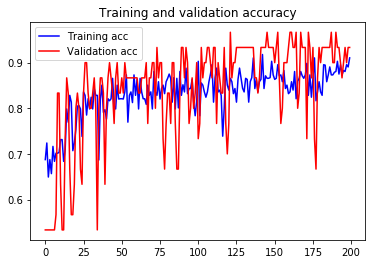

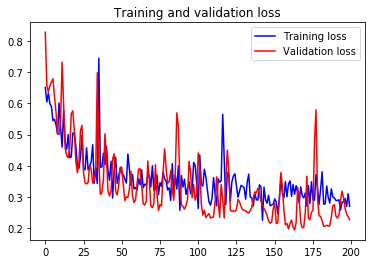

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()